In [2]:
from google.colab import drive
drive.mount("/content/drive")



Mounted at /content/drive


Encode to 1D matrix

In [3]:
import pandas, csv ,torch
from pandas import Series
def encode(s): #translate
    a = []
    dic = {'A':1,'B':22,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,
           'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,
           'V':18,'W':19,'Y':20,'X':21,'U':23,'J':24,'Z':25,'O':26}
    for c in s:
      a.append(dic[c])
    return a

def list2Tensor(l:list):
  return torch.tensor(l)

import numpy as np
def list2np(l:list):
  a = np.array(l)
  return a

def getSeqFamily():
  return pandas.read_csv("/content/drive/My Drive/PhagesClassificationByProtein_DeepLearning/Data/all_Prot_Seq.csv")


In [6]:

#get seqs and families 
df = getSeqFamily()
#shuffle
df = df.sample(frac=1).reset_index(drop=True)
#One hot encoding
one_hot = pandas.get_dummies(df["family"])
#Drop column B as it is now encoded
df = df.drop("family",axis = 1)
#Join the encoded df
df = df.join(one_hot)

print(df)
"""
#Convert family name to 0 - x(3)
families = df["family"]
families_np = families.to_numpy()
families_set = set(families_np)
families_list = list(families_set)
families_dict = {}
for i in range(len(families_list)):
  families_dict[families_list[i]] = i
print(families_dict)
"""


          prot_tag         prot_id  ... Podoviridae  Siphoviridae
0      AVU32_gp017  YP_009201120.1  ...           0             0
1       VPEG_00045  YP_004957538.1  ...           0             1
2       VPP93_gp14  YP_002875638.1  ...           1             0
3      AVV29_gp109  YP_009207567.1  ...           0             1
4       CF80_gp243  YP_009006317.1  ...           0             0
...            ...             ...  ...         ...           ...
2880    CF80_gp089  YP_009006163.1  ...           0             0
2881       pp2_266      AFN37499.1  ...           0             0
2882    VPFG_00098  YP_008125249.1  ...           0             0
2883  phiGrn1_0049      ALP47292.1  ...           0             0
2884    CF80_gp241  YP_009006315.1  ...           0             0

[2885 rows x 10 columns]


'\n#Convert family name to 0 - x(3)\nfamilies = df["family"]\nfamilies_np = families.to_numpy()\nfamilies_set = set(families_np)\nfamilies_list = list(families_set)\nfamilies_dict = {}\nfor i in range(len(families_list)):\n  families_dict[families_list[i]] = i\nprint(families_dict)\n'

Windows Function

In [5]:
def windows(iterable, n, m):
    res = []
    if m == 0: # otherwise infinte loop
        raise ValueError("Parameter 'm' can't be 0")
    lst = list(iterable)
    i = 0
    while i + n <= len(lst):
        res.append(lst[i:i + n])
        i += m
    temp = lst[i:]
    while (len(temp )) < n:
        temp.append(0)
    res.append(temp)
    #if remaining is less than n , give up
    return res
import random
def windowsRand(iterable, n, m,fragmentNo):
    res = []
    if m == 0: # otherwise infinte loop
        raise ValueError("Parameter 'm' can't be 0")
    lst = list(iterable)
    i = 0
    while i + n <= len(lst):
      
        #normal
        res.append(lst[i:i + n])
        #generate fragment to rand , padding zero
        for j in range(fragmentNo):
            #prevent getting too small value when n  is small
            start = i+1+int(n/4)
            #prevent same as generated one
            end = i+n-1
            rand = random.randint(start,end )
            temp = lst[i:rand]
            while (len(temp)) < n:
              temp.append(0)
            res.append(temp)
    
        i += m
    #For last one  
    temp = lst[i:]
    while (len(temp )) < n:
        temp.append(0)
    res.append(temp)
    #if remaining is less than n , give up
    return res

Config Torch dataset


In [14]:
import numpy as np

def findMaxLen(seqs):
  maxCount = 0
  for index , row in seqs.iteritems():
    maxCount = max(maxCount,len(str(row)))
  return maxCount

def encodeSeq(seqs,blockSize,families):
  l = []
  dic = {'A':1,'B':22,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,
      'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,
      'V':18,'W':19,'Y':20,'X':21,'U':23,'J':24,'Z':25,'O':26}

  #translate
  for index , row in seqs.iteritems():
    seq = []
    for c in str(row).upper():
      seq.append(dic[c])
    l.append(seq)
  # blockSize 

  #Fill zero to turn it to numpy array
  STEP = 1
  FRAGMENT_NO = 5
  outputSeqs = []
  outputFamilies = []
  for i in range(len(l)):
    combinations = windowsRand(l[i],blockSize,STEP,FRAGMENT_NO)
    for combination in combinations:
      outputSeqs.append(combination)
      outputFamilies.append(families[i])
  return np.array(outputSeqs),np.array(outputFamilies)



blockSize = 66
#Split config
SPLIT_RATIO = 0.8
END_INDEX = int(len(df.index)*SPLIT_RATIO)
#Split data
training_x = df.iloc[0:END_INDEX]["seq"]
test_x = df.iloc[END_INDEX:len(df.index)]["seq"]
training_y = df.iloc[0:END_INDEX][one_hot.columns]
test_y = df.iloc[END_INDEX:len(df.index)][one_hot.columns]

#Encode 
training_x_np ,training_y_np = encodeSeq(training_x,blockSize,training_y.values)
test_x_np ,test_y_np = encodeSeq(training_x,blockSize,training_y.values)
print(training_y_np.shape)

"""
#Encode x and to tensor
training_x_tensor = encodeSeq2Tensor(training_x,maxLen)
test_x_tensor = encodeSeq2Tensor(test_x,maxLen)
#Encode y and to Tensor
training_y_tensor = torch.tensor(training_y.values,dtype=torch.float)
test_y_tensor = torch.tensor(test_y.values,dtype=torch.float)
#Split seq in tensor if length >66 to numpy
print(np.array_split(training_x_tensor.numpy(),66))
"""

(2982574, 4)


'\n#Encode x and to tensor\ntraining_x_tensor = encodeSeq2Tensor(training_x,maxLen)\ntest_x_tensor = encodeSeq2Tensor(test_x,maxLen)\n#Encode y and to Tensor\ntraining_y_tensor = torch.tensor(training_y.values,dtype=torch.float)\ntest_y_tensor = torch.tensor(test_y.values,dtype=torch.float)\n#Split seq in tensor if length >66 to numpy\nprint(np.array_split(training_x_tensor.numpy(),66))\n'

In [15]:
print(test_x_np.shape)

(2982574, 66)


In [20]:
import pandas as pd
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.layers import Dense, LSTM, Lambda, TimeDistributed, Input, Masking, Bidirectional
from keras.optimizers import SGD , RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
# Embedding
max_features = 26
maxlen = 66
embedding_size = 50
# Convolution
nb_filter = 32
pool_length = 2
# BiLSTM
bilstm_output_size = 70

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(bilstm_output_size)))
model.add(Dense(4, activation='sigmoid'))
rmsprop = RMSprop(lr=0.005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=rmsprop,
      loss='categorical_crossentropy',
      metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath = "/content/drive/My Drive/PhagesClassificationByProtein_DeepLearning/Model", monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]
print(model.summary())

history = model.fit(training_x_np, training_y_np,validation_data=(test_x_np test_y_np) ,epochs=10, batch_size=1024 ,callbacks=callbacks_list,shuffle=True) 
#InputBlock(128, (num_features, ))
print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model.evaluate(test_x_np, test_y_np)

print('test loss: ', loss)
print('test accuracy: ', accuracy)



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 66, 50)            1300      
_________________________________________________________________
dropout_4 (Dropout)          (None, 66, 50)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 140)               67760     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 564       
Total params: 69,624
Trainable params: 69,624
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2913/2913 [==============================] - 91s 31ms/step - loss: 0.8189 - accuracy: 0.6483
Epoch 2/10
2913/2913 [==============================] - 92s 31ms/step - loss: 0.5132 - accuracy: 0.8024
Epoch 3/10
2913/2913 [=============

Save Model

In [21]:
model.save('fine_tune_model.h5')
model.save_weights('fine_tune_model_weight')

KeyError: ignored

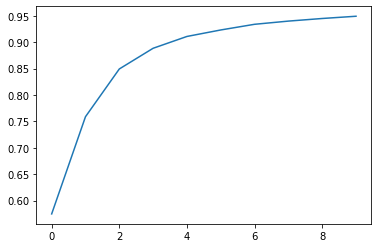

In [162]:
from keras.models import load_model
from keras.utils import plot_model



def poltModel():
    plot_model(model, to_file='model.png', show_shapes='True')
poltModel()

Create Dataset

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class DatasetIterater(Dataset):
    def __init__(self,seqs,families):
        self.seqs = seqs
        self.families = families
 
    def __getitem__(self, index):
        return self.seqs[index],self.families[index]
 
    def __len__(self):
        return len(self.seqs)

train_data = DatasetIterater(training_x_tensor,training_y_tensor) 
test_data = DatasetIterater(training_x_tensor,test_y_tensor)   

# Create train/valid loaders
train_loader = DataLoader(
    dataset=train_data, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(
    dataset=test_data, batch_size=16, shuffle=False, num_workers=4)

for imgs, lbls in train_loader:
    print('Size of image:', imgs)  # batch_size * 3 * 224 * 224
    print('Type of image:', imgs.dtype)   # float32
    print('Size of label:', lbls)  # batch_size
    print('Type of label:', lbls.dtype)   # int64(long)
    break

Size of image: tensor([[11., 16.,  5.,  ...,  0.,  0.,  0.],
        [11., 16., 14.,  ...,  0.,  0.,  0.],
        [11.,  6., 19.,  ...,  0.,  0.,  0.],
        ...,
        [11.,  8., 10.,  ...,  0.,  0.,  0.],
        [11., 16., 18.,  ...,  0.,  0.,  0.],
        [11., 17.,  3.,  ...,  0.,  0.,  0.]])
Type of image: torch.float32
Size of label: tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])
Type of label: torch.float32


Define CNN model

In [122]:
# GPU
!nvidia-smi -L
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                #26 char + 1 padding zero
                in_channels = 26+1,
                #maxLen 3344
                out_channels = 50,
                kernel_size = 1
            ),
            nn.MaxPool1d(kernel_size=1),
            nn.ReLU(),
            
        )
        self.conv2 = nn.Sequential(
             nn.Conv1d(
                 in_channels=50, 
                 out_channels=100, 
                 kernel_size=2, 
            ),
            nn.MaxPool1d(kernel_size=1),
            nn.ReLU(),
        )


    def forward(self, x):
      #（batch_size,word_vector,sequence_length）
      #input.shape:(16,1,maxLen)
      x = self.conv1(x)
      x = self.conv2(x)
      x = x.view(x.size(0),-1)
      return x

cnn = CNN()
#print(cnn)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)  
loss_func = nn.BCEWithLogitsLoss()

GPU 0: Tesla T4 (UUID: GPU-a08e2a1a-d533-ea0e-a517-13068b928fca)
GPU State: cuda:0


Train Model

In [ ]:
# training and testing
EPOCH = 1  
for epoch in range(EPOCH):
  for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
      output = cnn(b_x)               # cnn output
      loss = loss_func(output, b_y)   # cross entropy loss
      optimizer.zero_grad()           # clear gradients for this training step
      loss.backward()                 # backpropagation, compute gradients
      optimizer.step()                # apply gradients

      if step % 50 == 0:
        test_output, last_layer = cnn(test_x)
        pred_y = torch.max(test_output, 1)[1].data.numpy()
        accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

RuntimeError: ignored

In [ ]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F


Try catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.1MB 48kB/s 


In [ ]:
from Bio import Entrez, SeqIO
from datetime import datetime
import time ,random
from multiprocessing import Process
from multiprocessing import Pool
import multiprocessing
import pandas, csv


def readCSV():
    for csv in CSVs:
        try:
            data = pandas.read_csv("/content/drive/My Drive/FYP/"+csv)
            data = data.dropna(how='all')
            print(data)
        except Exception as e:
            print(e)
            data = data.dropna(how='all')
            data = pandas.read_csv(csv)
            print(data)
        dataL.append(data)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


        prot_tag         prot_id  ... Unnamed: 1023 Unnamed: 1024
0     VPKG_00030  YP_007673992.1  ...           NaN           NaN
1      AEO54_249      AKY02254.1  ...           NaN           NaN
2    AVV29_gp087  YP_009207589.1  ...           NaN           NaN
3      AEO54_253      AKY02255.1  ...           NaN           NaN
4    THALASSA_37      AUG85239.1  ...           NaN           NaN
..           ...             ...  ...           ...           ...
316   VPEG_00085  YP_004957577.1  ...           NaN           NaN
317   AOQ26687.1      AOQ26687.1  ...           NaN           NaN
318   AEH21887.1      AEH21887.1  ...           NaN           NaN
319   AEH21815.1      AEH21815.1  ...           NaN           NaN
320    SHOU24_91  YP_009006492.1  ...           NaN           NaN

[321 rows x 1025 columns]
05:00:40 Sipho_Prot_Seq.csv Doing index:0 YP_007673992.1
05:00:40 Sipho_Prot_Seq.csv Doing index:1 AKY02254.1
05:00:40 Sipho_Prot_Seq.csv Doing index:2 YP_009207589.1
05:00:40 Sipho